Training High Volume Models...
Best XGBoost params: {'subsample': 0.9, 'n_estimators': 7000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10501, number of used features: 14
[LightGBM] [Info] Start training from score 4.153746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

<Figure size 1000x600 with 0 Axes>

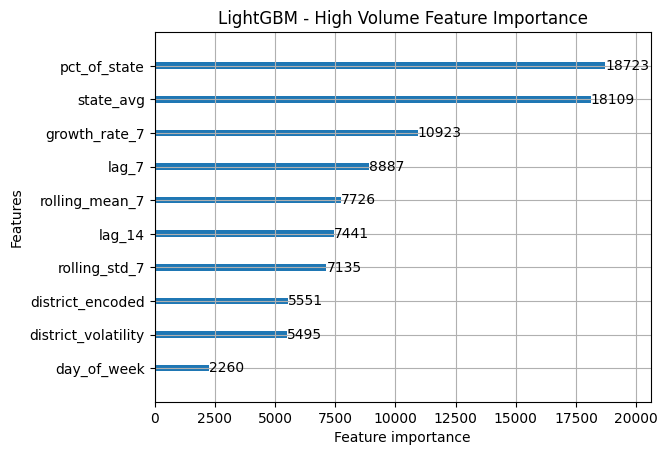

<Figure size 1000x600 with 0 Axes>

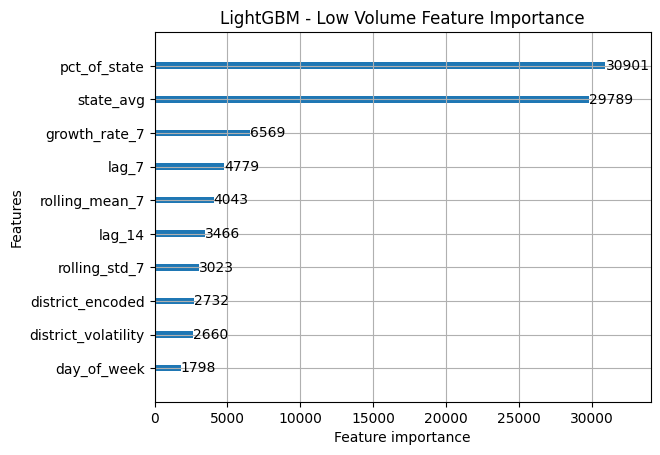

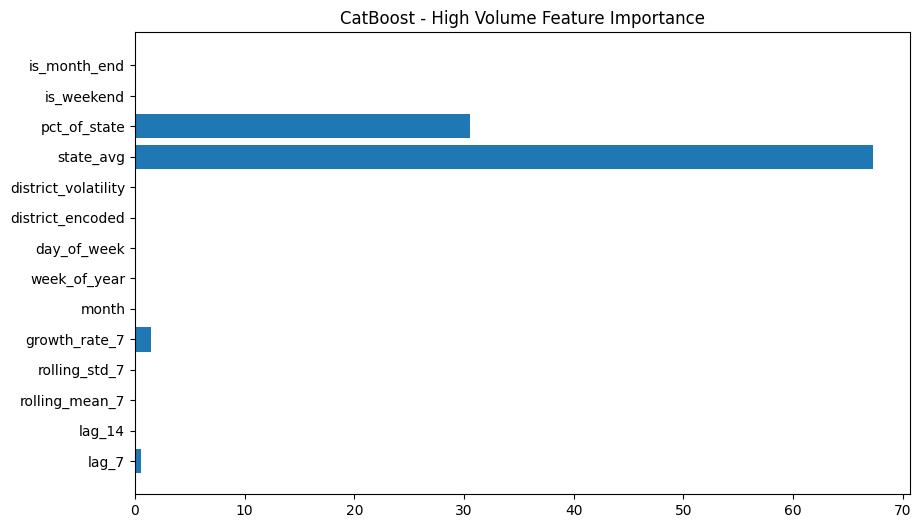

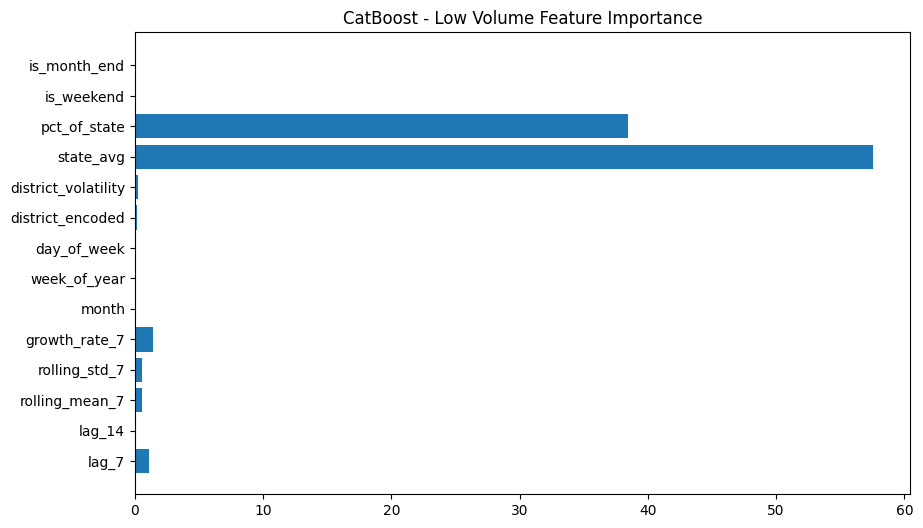


Pipeline Complete with Plots and Error Analysis!


In [3]:
# ======= District Level Aadhaar Enrollment Forecasting - FULL PIPELINE =======

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Wrapper for CatBoost to make it sklearn-compatible
class SklearnCompatibleCatBoost(BaseEstimator):
    def __init__(self, iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', random_seed=42, verbose=False, subsample=1.0, colsample_bylevel=1.0):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.loss_function = loss_function
        self.random_seed = random_seed
        self.verbose = verbose
        self.subsample = subsample
        self.colsample_bylevel = colsample_bylevel

    def fit(self, X, y, eval_set=None, early_stopping_rounds=None, **kwargs):
        self.model_ = cb.CatBoostRegressor(
            iterations=self.iterations,
            learning_rate=self.learning_rate,
            depth=self.depth,
            loss_function=self.loss_function,
            random_seed=self.random_seed,
            verbose=self.verbose,
            subsample=self.subsample,
            colsample_bylevel=self.colsample_bylevel
        )
        self.model_.fit(X, y, eval_set=eval_set, early_stopping_rounds=early_stopping_rounds, **kwargs)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def get_feature_importance(self):
        return self.model_.get_feature_importance()

# ---------------- Reproducibility ----------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ---------------- Load Data ----------------
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Aggregate to district level
df_agg = df.groupby(['state', 'district', 'date'])['total_enrollment'].sum().reset_index()
df_agg = df_agg.sort_values(['district', 'date']).reset_index(drop=True)

# Target transformation
df_agg['target'] = np.log(df_agg['total_enrollment'] + 1)

# ---------------- Feature Engineering ----------------
df_agg = df_agg.sort_values(['district', 'date'])

df_agg['lag_7'] = df_agg.groupby('district')['total_enrollment'].shift(7)
df_agg['lag_14'] = df_agg.groupby('district')['total_enrollment'].shift(14)

df_agg['rolling_mean_7'] = df_agg.groupby('district')['total_enrollment'] \
                                 .transform(lambda x: x.shift(7).rolling(7).mean())

df_agg['rolling_std_7'] = df_agg.groupby('district')['total_enrollment'] \
                                .transform(lambda x: x.shift(7).rolling(7).std())


df_agg['growth_rate_7'] = (df_agg['total_enrollment'] - df_agg['lag_7']) / df_agg['lag_7']
df_agg['growth_rate_7'] = df_agg['growth_rate_7'].replace([np.inf, -np.inf], np.nan)

df_agg['month'] = df_agg['date'].dt.month
df_agg['week_of_year'] = df_agg['date'].dt.isocalendar().week.astype(int)
df_agg['day_of_week'] = df_agg['date'].dt.dayofweek

df_agg['state_avg'] = df_agg.groupby(['state', 'date'])['total_enrollment'].transform('mean')
df_agg['pct_of_state'] = df_agg['total_enrollment'] / df_agg['state_avg']

df_agg['is_weekend'] = df_agg['day_of_week'].isin([5, 6]).astype(int)
df_agg['is_month_end'] = (df_agg['date'].dt.day > 25).astype(int)

train_mask = df_agg['date'].dt.month.isin([3,4,5,6,7,8,9,10])

district_mean = df_agg[train_mask].groupby('district')['total_enrollment'].mean()
district_std = df_agg[train_mask].groupby('district')['total_enrollment'].std()

df_agg['district_encoded'] = df_agg['district'].map(district_mean)
df_agg['district_volatility'] = df_agg['district'].map(district_std)

features = [
    'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_std_7',
    'growth_rate_7', 'month', 'week_of_year', 'day_of_week',
    'district_encoded', 'district_volatility',
    'state_avg', 'pct_of_state', 'is_weekend', 'is_month_end'
]

df_agg = df_agg.dropna(subset=features + ['target'])

# ---------------- Train / Val / Test Split ----------------
val_mask = df_agg['date'].dt.month == 11
test_mask = df_agg['date'].dt.month == 12

X = df_agg[features]
y = df_agg['target']
y_original = df_agg['total_enrollment']

X_train = X.loc[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test_orig = y_original[test_mask]

# ---------------- High / Low Volume Split ----------------
test_district_means = df_agg[test_mask].groupby('district')['total_enrollment'].mean()
threshold = test_district_means.quantile(0.60)

high_volume_mask = df_agg['district'].map(test_district_means > threshold).fillna(False)
low_volume_mask = ~high_volume_mask

X_train_high = X_train[high_volume_mask[train_mask]]
y_train_high = y_train[high_volume_mask[train_mask]]

X_val_high = X_val[high_volume_mask[val_mask]]
y_val_high = y_val[high_volume_mask[val_mask]]

X_test_high = X_test[high_volume_mask[test_mask]]
y_test_high_orig = y_test_orig[high_volume_mask[test_mask]]

X_train_low = X_train[low_volume_mask[train_mask]]
y_train_low = y_train[low_volume_mask[train_mask]]

X_val_low = X_val[low_volume_mask[val_mask]]
y_val_low = y_val[low_volume_mask[val_mask]]

X_test_low = X_test[low_volume_mask[test_mask]]
y_test_low_orig = y_test_orig[low_volume_mask[test_mask]]

# ---------------- Model Training Function with RandomizedSearchCV ----------------
def train_models(X_tr, y_tr, X_v, y_v):
    # XGBoost
    param_dist_xgb = {
        'n_estimators': [5000, 7000, 8000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model_xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)
    search_xgb = RandomizedSearchCV(model_xgb_base, param_dist_xgb, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=RANDOM_SEED, n_jobs=-1)
    search_xgb.fit(X_tr, y_tr)
    best_params_xgb = search_xgb.best_params_
    print(f"Best XGBoost params: {best_params_xgb}")
    model_xgb = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror', eval_metric="mae", early_stopping_rounds=150, random_state=RANDOM_SEED)
    model_xgb.fit(X_tr, y_tr, eval_set=[(X_v, y_v)], verbose=False)

    # LightGBM
    param_dist_lgb = {
        'n_estimators': [5000, 7000, 8000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'num_leaves': [20, 31, 50],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model_lgb_base = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_SEED)
    search_lgb = RandomizedSearchCV(model_lgb_base, param_dist_lgb, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=RANDOM_SEED, n_jobs=-1)
    search_lgb.fit(X_tr, y_tr)
    best_params_lgb = search_lgb.best_params_
    print(f"Best LightGBM params: {best_params_lgb}")
    model_lgb = lgb.LGBMRegressor(**best_params_lgb, objective='regression', random_state=RANDOM_SEED)
    model_lgb.fit(X_tr, y_tr, eval_set=[(X_v, y_v)], callbacks=[lgb.early_stopping(150)])

    # CatBoost
    param_dist_cb = {
        'iterations': [5000, 7000, 8000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bylevel': [0.8, 0.9, 1.0]
    }
    model_cb_base = SklearnCompatibleCatBoost(loss_function='MAE', random_seed=RANDOM_SEED, verbose=False)
    search_cb = RandomizedSearchCV(model_cb_base, param_dist_cb, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=RANDOM_SEED, n_jobs=-1)
    search_cb.fit(X_tr, y_tr)
    best_params_cb = search_cb.best_params_
    print(f"Best CatBoost params: {best_params_cb}")
    model_cb = SklearnCompatibleCatBoost(**best_params_cb, loss_function='MAE', random_seed=RANDOM_SEED, verbose=False)
    model_cb.fit(X_tr, y_tr, eval_set=(X_v, y_v), early_stopping_rounds=150)

    return model_xgb, model_lgb, model_cb

# Train models
print("Training High Volume Models...")
model_high_xgb, model_high_lgb, model_high_cb = train_models(
    X_train_high, y_train_high, X_val_high, y_val_high
)

print("Training Low Volume Models...")
model_low_xgb, model_low_lgb, model_low_cb = train_models(
    X_train_low, y_train_low, X_val_low, y_val_low
)

# ---------------- Weight Optimization ----------------
def optimize_weights(preds, true):
    def loss(weights):
        ensemble = np.average(preds, axis=0, weights=weights)
        return mean_absolute_error(true, ensemble)

    result = minimize(
        loss,
        [1/3, 1/3, 1/3],
        bounds=[(0,1)]*3,
        constraints={'type': 'eq', 'fun': lambda w: sum(w) - 1}
    )
    return result.x

val_preds_high = [
    model_high_xgb.predict(X_val_high),
    model_high_lgb.predict(X_val_high),
    model_high_cb.predict(X_val_high)
]

val_preds_low = [
    model_low_xgb.predict(X_val_low),
    model_low_lgb.predict(X_val_low),
    model_low_cb.predict(X_val_low)
]

weights_high = optimize_weights(val_preds_high, y_val_high)
weights_low = optimize_weights(val_preds_low, y_val_low)

print("Optimized Weights High:", weights_high)
print("Optimized Weights Low:", weights_low)

# ---------------- Final Test Predictions ----------------
test_preds_high = [
    model_high_xgb.predict(X_test_high),
    model_high_lgb.predict(X_test_high),
    model_high_cb.predict(X_test_high)
]

test_preds_low = [
    model_low_xgb.predict(X_test_low),
    model_low_lgb.predict(X_test_low),
    model_low_cb.predict(X_test_low)
]

y_pred_high = np.average(test_preds_high, axis=0, weights=weights_high)
y_pred_low = np.average(test_preds_low, axis=0, weights=weights_low)

y_pred_high_orig = np.exp(y_pred_high) - 1
y_pred_low_orig = np.exp(y_pred_low) - 1

y_test_pred_combined = pd.concat([
    pd.Series(y_pred_high_orig, index=y_test_high_orig.index),
    pd.Series(y_pred_low_orig, index=y_test_low_orig.index)
]).sort_index()

# ---------------- Final Evaluation ----------------
mae = mean_absolute_error(y_test_orig, y_test_pred_combined)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_combined))
mape = mean_absolute_percentage_error(y_test_orig, y_test_pred_combined)

print("\nFINAL RESULTS")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.4f}")

# ---------------- Error by Magnitude ----------------
errors_test = pd.DataFrame({
    'actual': y_test_orig,
    'pred': y_test_pred_combined,
    'abs_error': np.abs(y_test_orig - y_test_pred_combined)
})

errors_test['magnitude'] = pd.cut(
    errors_test['actual'],
    bins=[0, 100, 500, np.inf],
    labels=['small', 'medium', 'large']
)

mag_errors = errors_test.groupby('magnitude', observed=False)['abs_error'].mean()

print("\nError by Magnitude:")
print(mag_errors)

# ---------------- Feature Importance Plots ----------------
print("\nGenerating Feature Importance Plots...")

plt.figure(figsize=(10,6))
lgb.plot_importance(model_high_lgb, max_num_features=10)
plt.title("LightGBM - High Volume Feature Importance")
plt.show()

plt.figure(figsize=(10,6))
lgb.plot_importance(model_low_lgb, max_num_features=10)
plt.title("LightGBM - Low Volume Feature Importance")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(features, model_high_cb.get_feature_importance())
plt.title("CatBoost - High Volume Feature Importance")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(features, model_low_cb.get_feature_importance())
plt.title("CatBoost - Low Volume Feature Importance")
plt.show()

print("\nPipeline Complete with Plots and Error Analysis!")

In [4]:
# After computing weights_high and weights_low, add this code to save them

import numpy as np
import os

# Define save path (adjust as needed)
save_dir = r'S:\UIDAI_Hackathon\models'
os.makedirs(save_dir, exist_ok=True)

# Save weights
np.save(os.path.join(save_dir, 'weights_high.npy'), weights_high)
np.save(os.path.join(save_dir, 'weights_low.npy'), weights_low)

print("Weights saved successfully!")

Weights saved successfully!


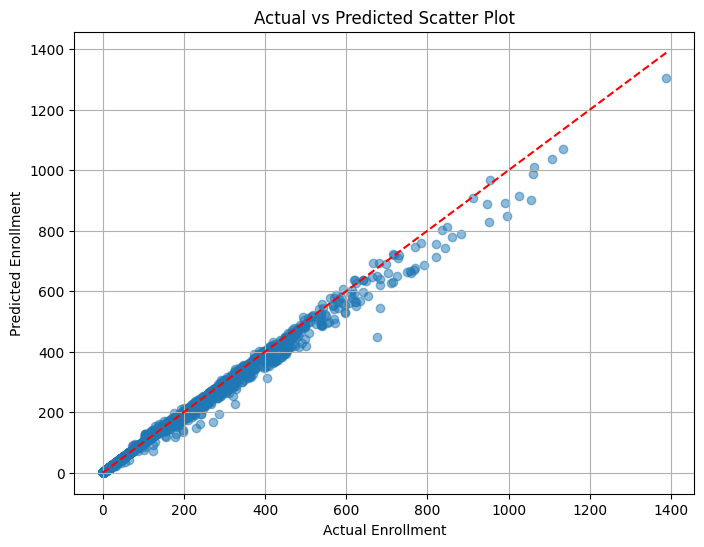

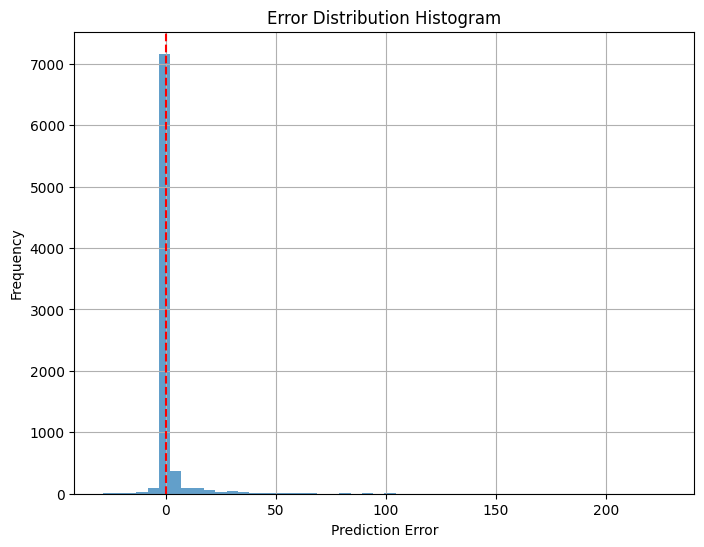

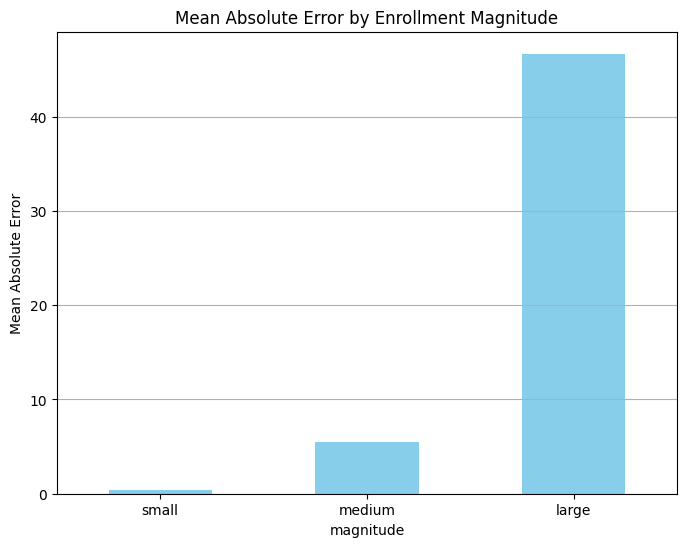

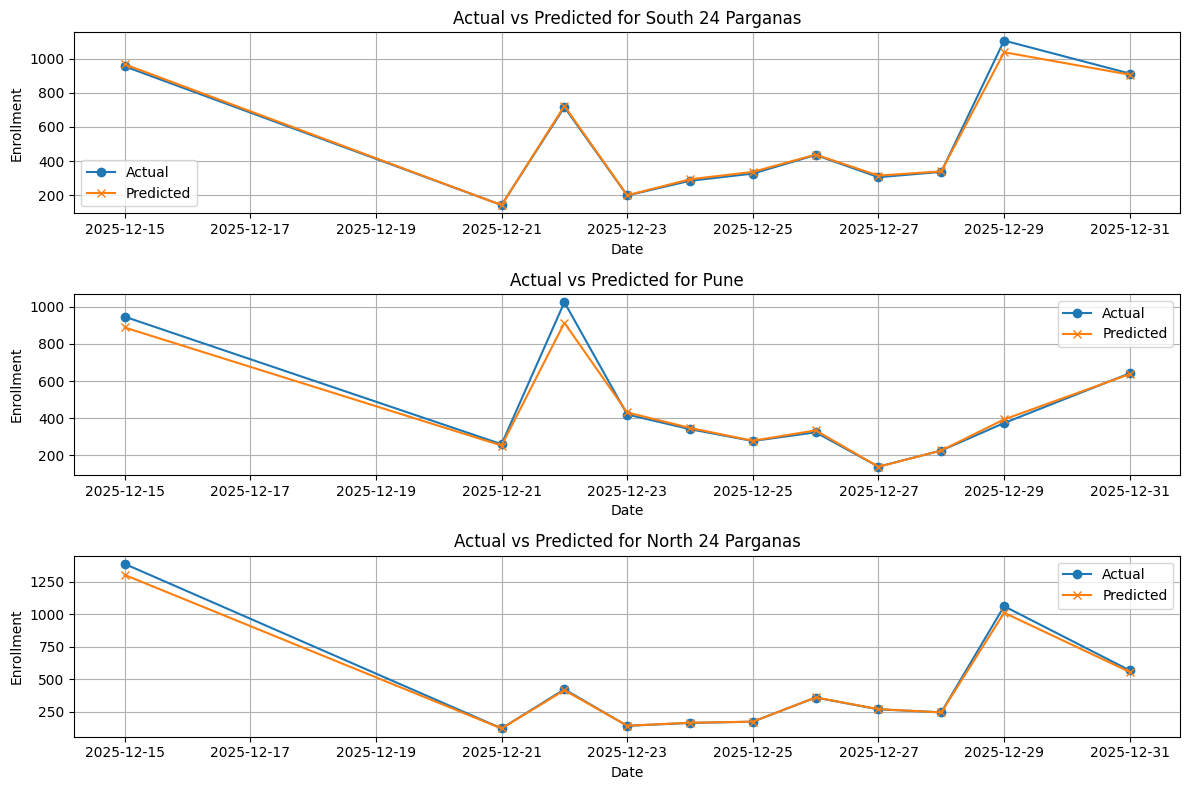

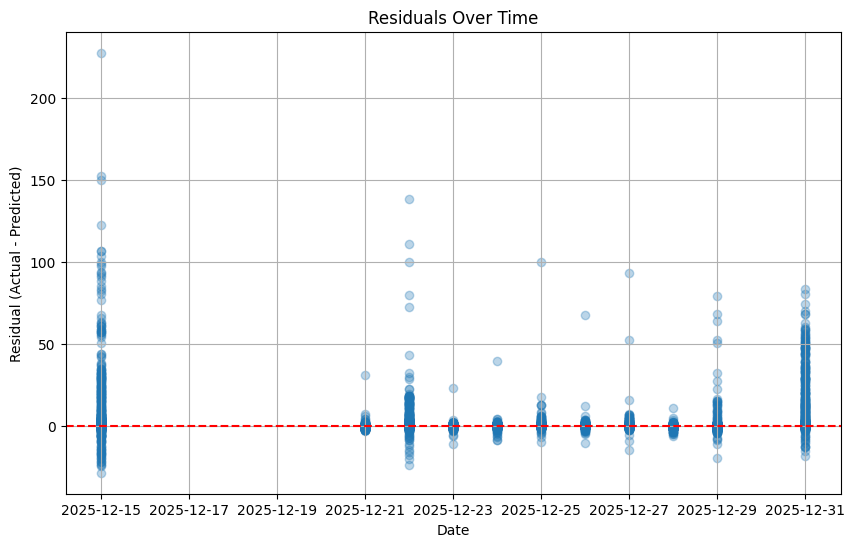

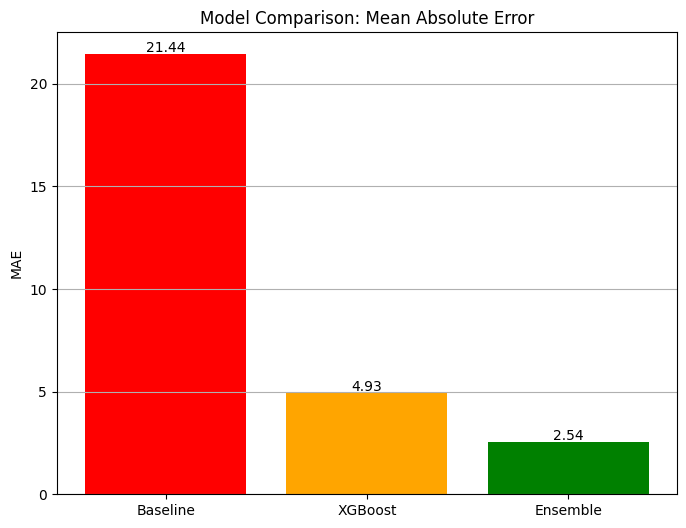

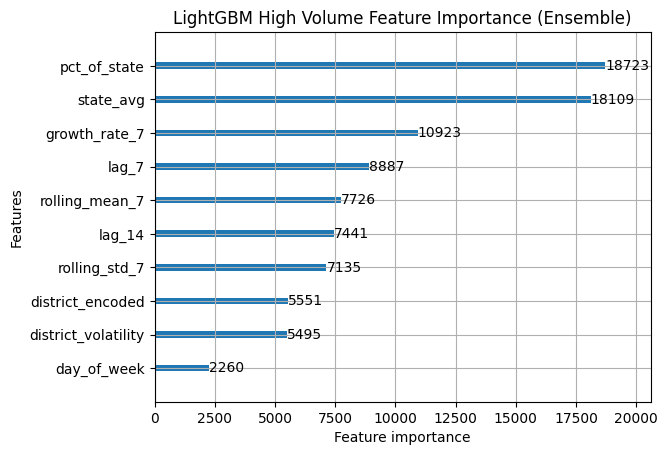

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_27248\2252321512.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([small_errors_pct, medium_errors_pct, large_errors_pct], labels=['Small', 'Medium', 'Large'])


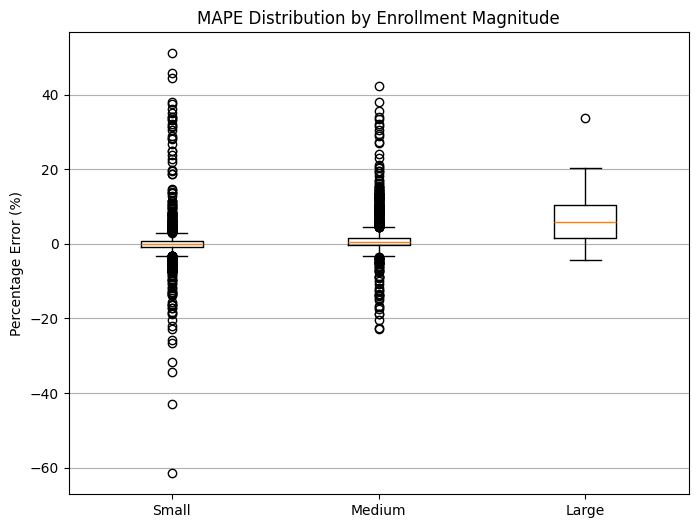

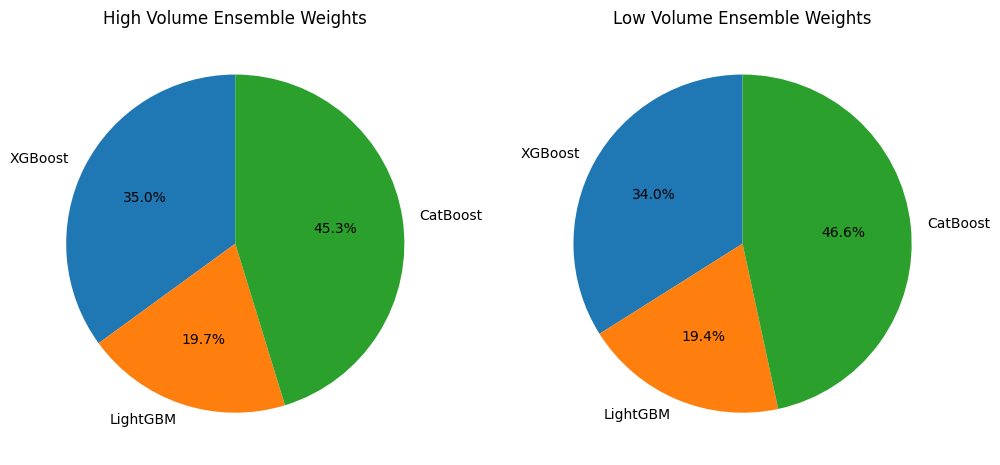

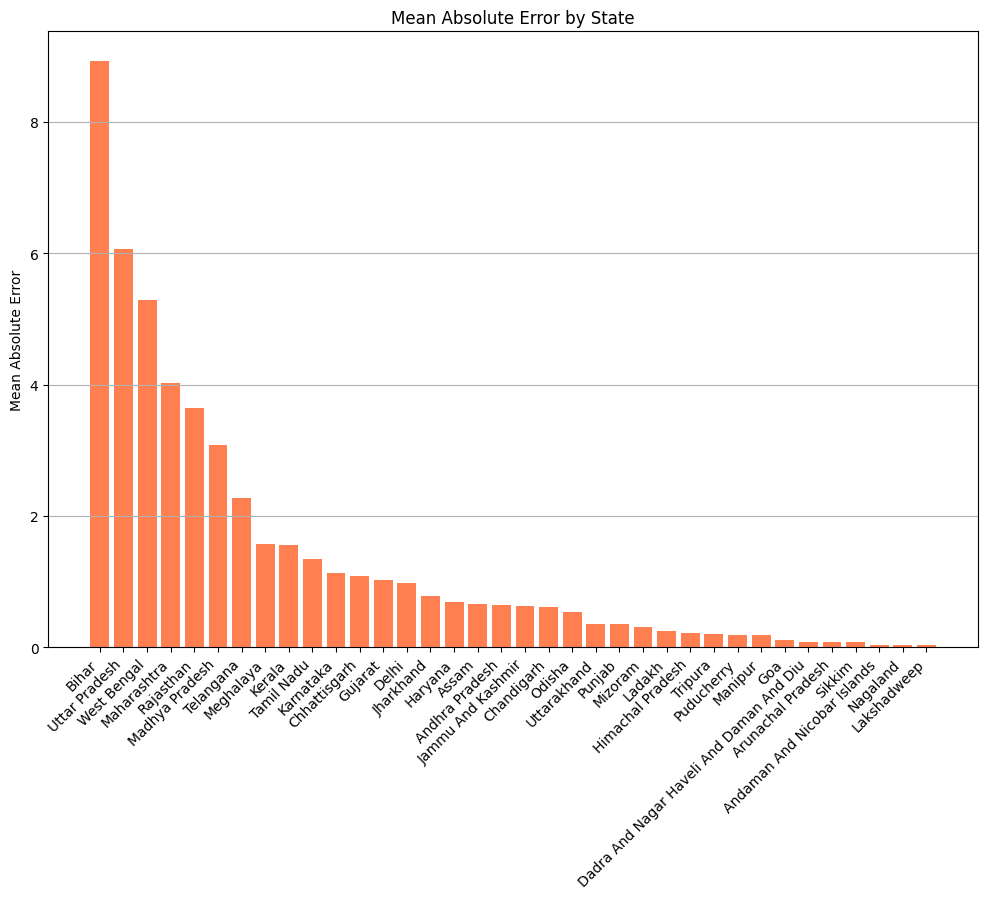

All visualizations complete.


In [5]:
# Ensemble Model Visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plots
df_test = df_agg[test_mask].copy()
df_test['pred'] = y_test_pred_combined
df_test['abs_error'] = np.abs(df_test['total_enrollment'] - df_test['pred'])
df_test['error'] = df_test['total_enrollment'] - df_test['pred']
df_test['error_pct'] = df_test['error'] / df_test['total_enrollment'] * 100
df_test['magnitude'] = pd.cut(df_test['total_enrollment'], bins=[0, 100, 500, np.inf], labels=['small', 'medium', 'large'])

# 1. Actual vs Predicted Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test_orig, y_test_pred_combined, alpha=0.5)
plt.plot([0, max(y_test_orig)], [0, max(y_test_orig)], 'r--')
plt.xlabel('Actual Enrollment')
plt.ylabel('Predicted Enrollment')
plt.title('Actual vs Predicted Scatter Plot')
plt.grid(True)
plt.show()

# 2. Error Distribution Histogram
plt.figure(figsize=(8,6))
errors = y_test_orig - y_test_pred_combined
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution Histogram')
plt.grid(True)
plt.show()

# 3. Error by Magnitude Bar Chart
plt.figure(figsize=(8,6))
mag_errors.plot(kind='bar', color='skyblue')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Enrollment Magnitude')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.show()

# 4. Time Series: Actual vs Predicted (sample districts)
# Select top 3 districts by mean enrollment
top_districts = df_test.groupby('district')['total_enrollment'].mean().nlargest(3).index.tolist()
plt.figure(figsize=(12,8))
for i, district in enumerate(top_districts):
    plt.subplot(3,1,i+1)
    mask = df_test['district'] == district
    dates = df_test[mask]['date']
    actual = df_test[mask]['total_enrollment']
    pred = df_test[mask]['pred']
    plt.plot(dates, actual, label='Actual', marker='o')
    plt.plot(dates, pred, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted for {district}')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Residuals Over Time
plt.figure(figsize=(10,6))
plt.scatter(df_test['date'], df_test['error'], alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.grid(True)
plt.show()

# 6. Model Comparison Bar Chart
models = ['Baseline', 'XGBoost', 'Ensemble']
mae_scores = [21.44, 4.93, 2.54]  # From previous results
plt.figure(figsize=(8,6))
plt.bar(models, mae_scores, color=['red', 'orange', 'green'])
plt.ylabel('MAE')
plt.title('Model Comparison: Mean Absolute Error')
plt.grid(True, axis='y')
for i, v in enumerate(mae_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.show()

# 7. Feature Importance (Top 10) - Already in previous cell, but repeat for ensemble context
# Using LightGBM high volume as example
lgb.plot_importance(model_high_lgb, max_num_features=10)
plt.title("LightGBM High Volume Feature Importance (Ensemble)")
plt.show()

# 8. MAPE by District Size (Box Plot)
small_errors_pct = df_test[df_test['magnitude']=='small']['error_pct']
medium_errors_pct = df_test[df_test['magnitude']=='medium']['error_pct']
large_errors_pct = df_test[df_test['magnitude']=='large']['error_pct']
plt.figure(figsize=(8,6))
plt.boxplot([small_errors_pct, medium_errors_pct, large_errors_pct], labels=['Small', 'Medium', 'Large'])
plt.ylabel('Percentage Error (%)')
plt.title('MAPE Distribution by Enrollment Magnitude')
plt.grid(True, axis='y')
plt.show()

# 9. Ensemble Weight Pie Charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.pie(weights_high, labels=['XGBoost', 'LightGBM', 'CatBoost'], autopct='%1.1f%%', startangle=90)
ax1.set_title('High Volume Ensemble Weights')
ax2.pie(weights_low, labels=['XGBoost', 'LightGBM', 'CatBoost'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Low Volume Ensemble Weights')
plt.show()

# Bonus: Heatmap of Errors by State (Bar Chart)
error_by_state = df_test.groupby('state')['abs_error'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.bar(error_by_state.index, error_by_state.values, color='coral')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by State')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.show()

print("All visualizations complete.")

Computing SHAP values for high-volume models...
Computing SHAP values for low-volume models...


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_27248\2514737746.py:48: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_high_ensemble, X_val_high, feature_names=features, show=False)


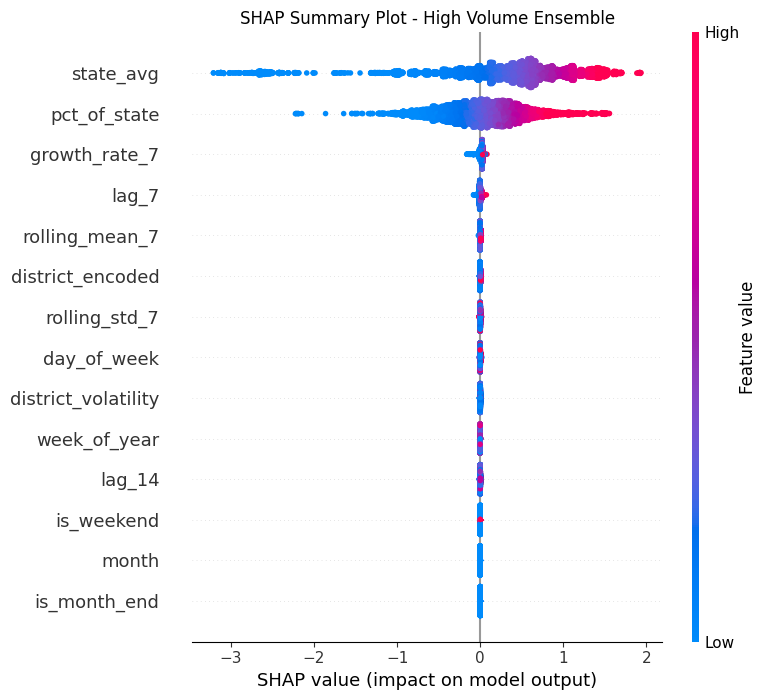

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_27248\2514737746.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_low_ensemble, X_val_low, feature_names=features, show=False)


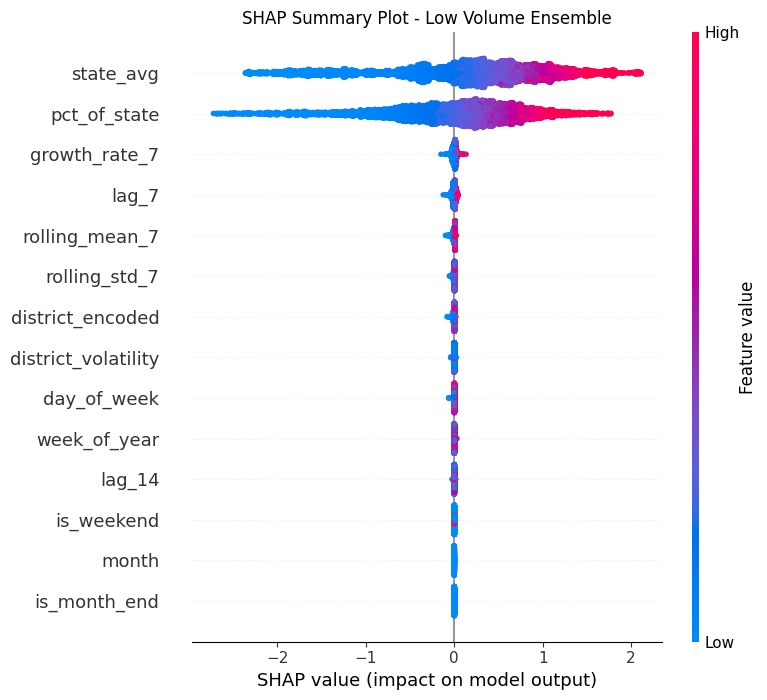

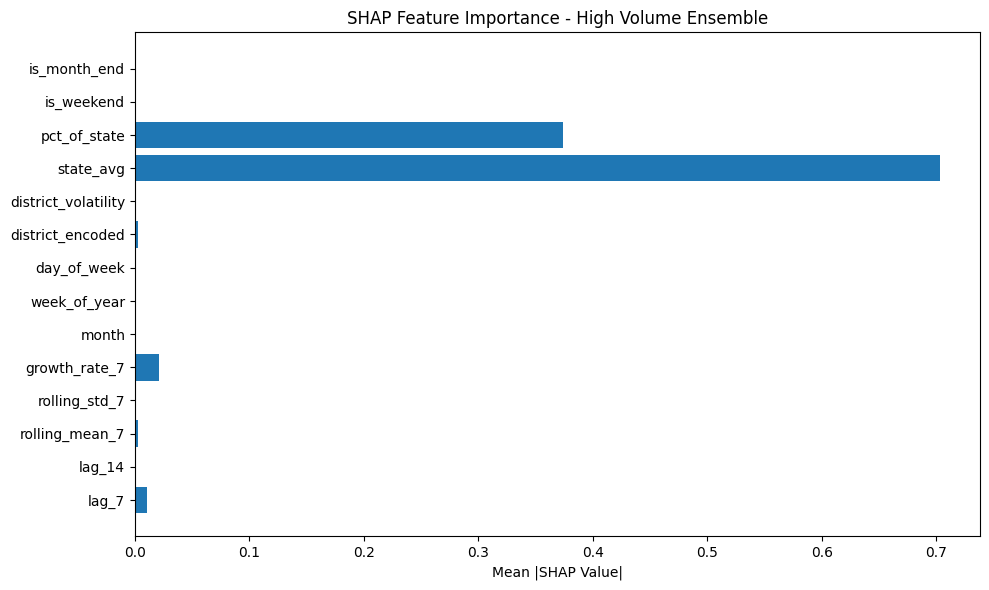

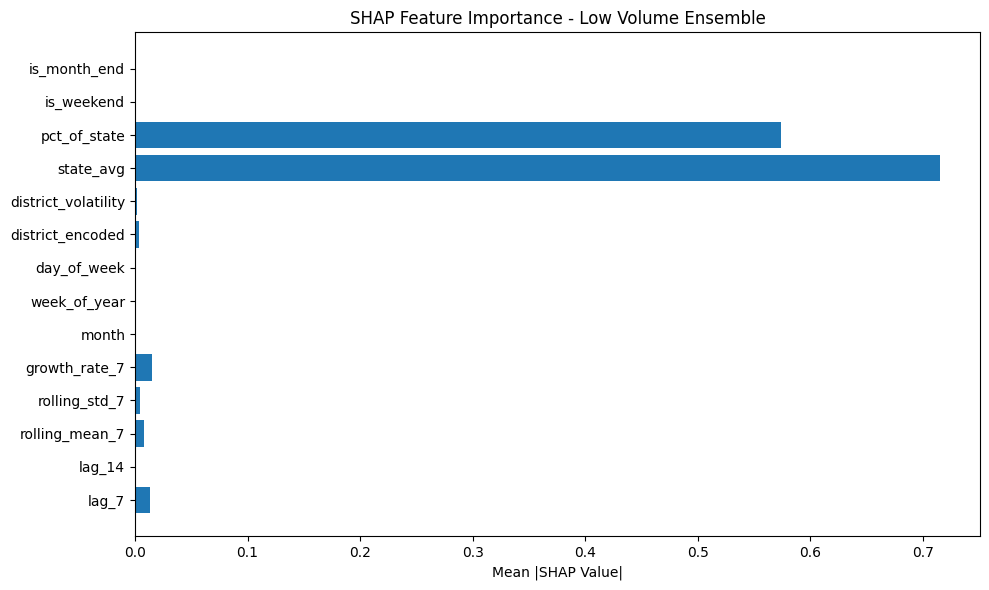

<Figure size 800x600 with 0 Axes>

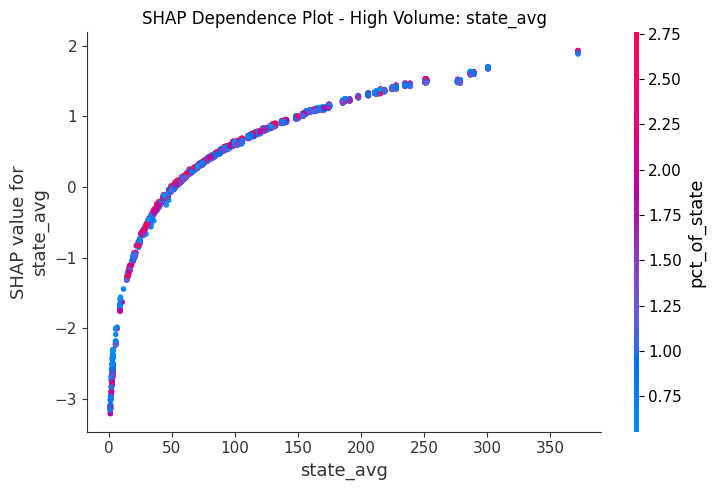

<Figure size 800x600 with 0 Axes>

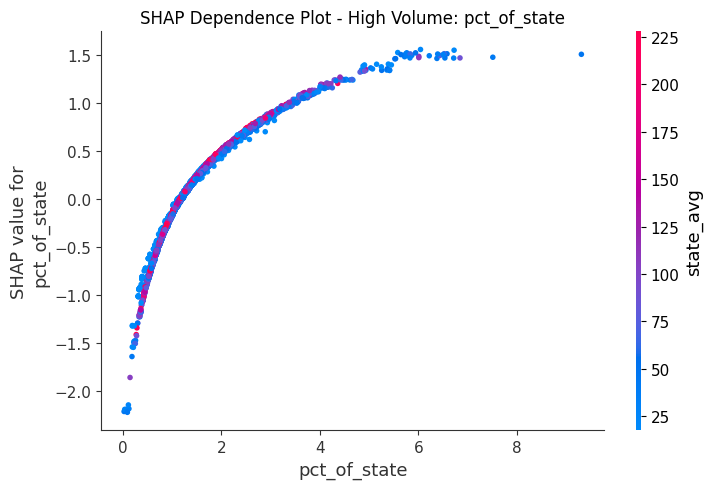

<Figure size 800x600 with 0 Axes>

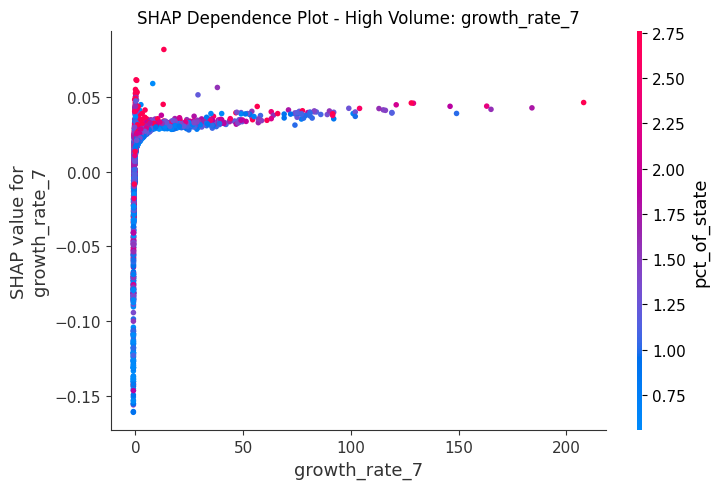

<Figure size 800x600 with 0 Axes>

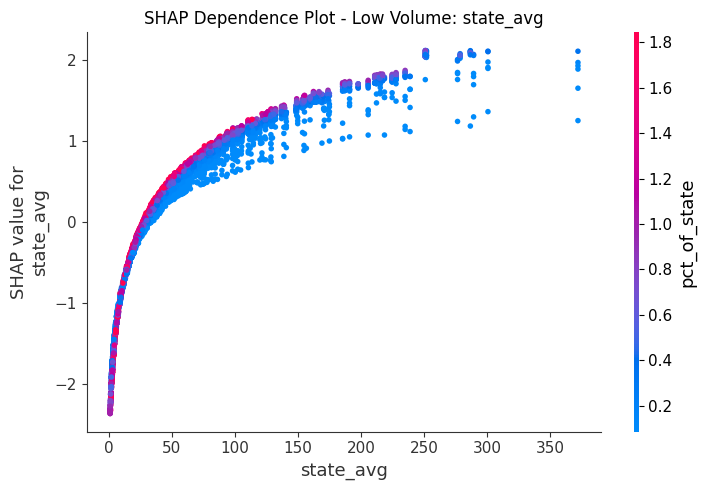

<Figure size 800x600 with 0 Axes>

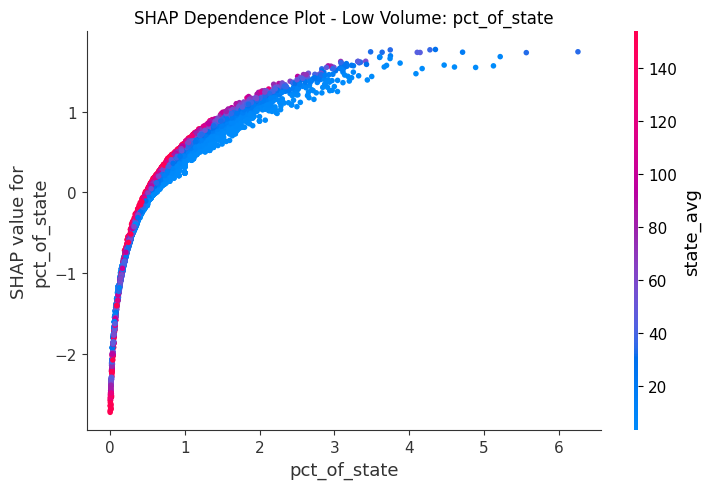

<Figure size 800x600 with 0 Axes>

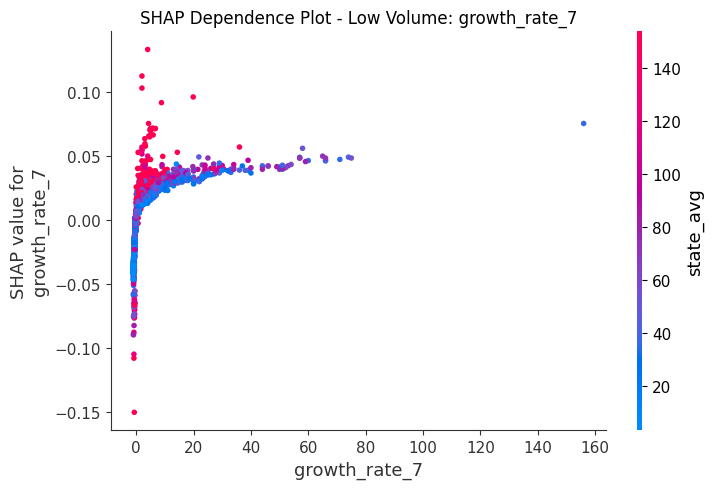

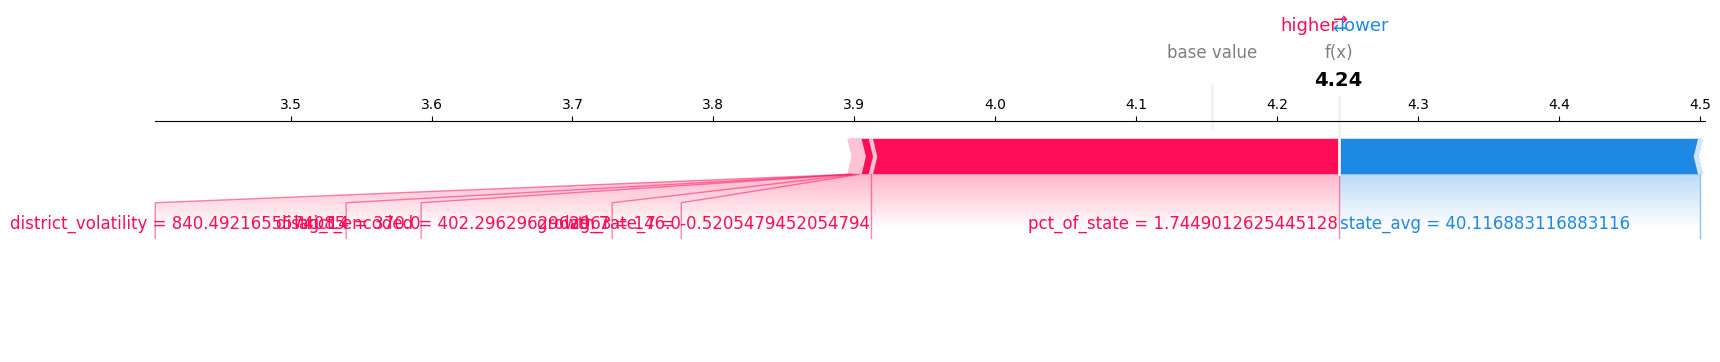

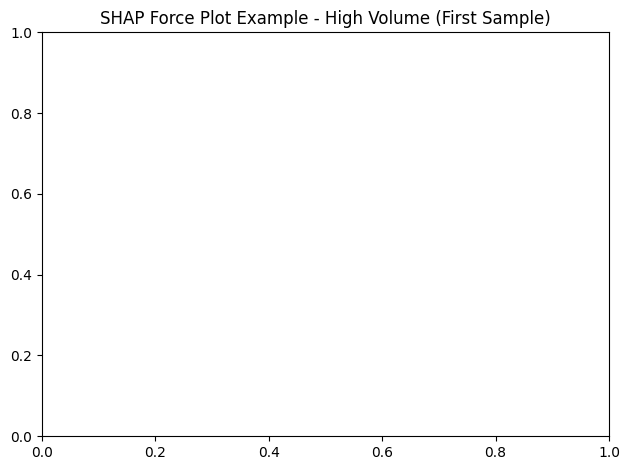

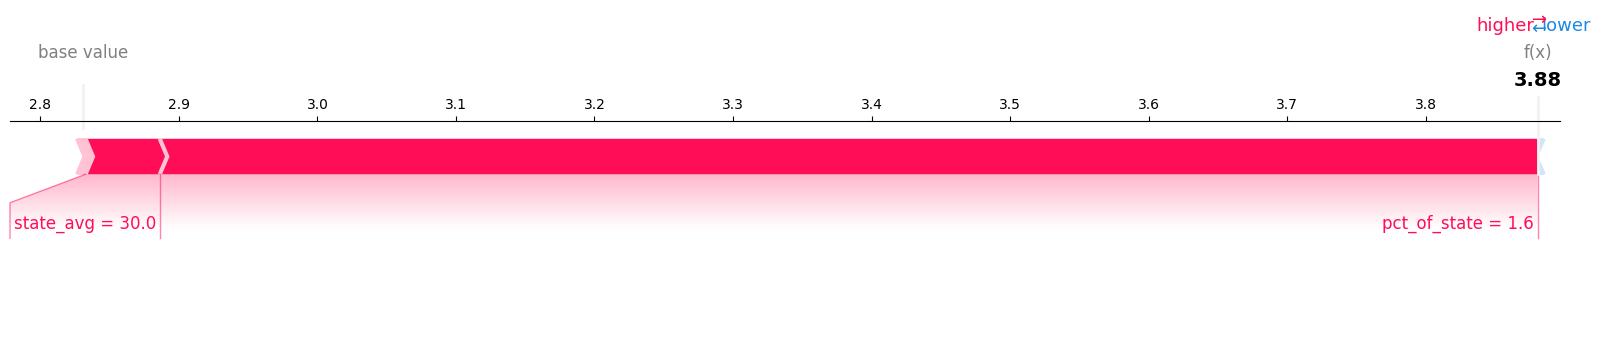

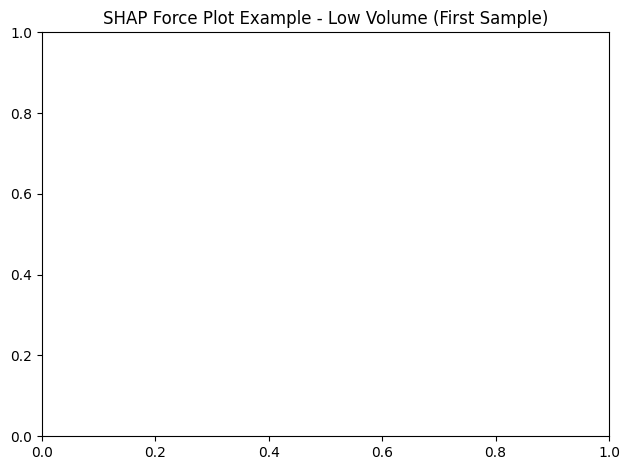

SHAP analysis complete. All plots and data saved to reports directory.


In [7]:
# SHAP Explainability Analysis for Ensemble Models

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Create reports directory if not exists
reports_dir = r'S:\UIDAI_Hackathon\reports'
os.makedirs(reports_dir, exist_ok=True)

# Function to compute SHAP values for a model
def compute_shap_values(model, X_val, model_name, explainer_type='tree'):
    # Handle custom wrapper for CatBoost
    if hasattr(model, 'model_') and 'CatBoost' in str(type(model.model_)):
        explainer = shap.TreeExplainer(model.model_)
    else:
        if explainer_type == 'tree':
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.Explainer(model)
    
    shap_values = explainer.shap_values(X_val)
    return shap_values, explainer

# Compute SHAP for individual models on validation sets
print("Computing SHAP values for high-volume models...")
shap_high_xgb, _ = compute_shap_values(model_high_xgb, X_val_high, 'High_XGB')
shap_high_lgb, _ = compute_shap_values(model_high_lgb, X_val_high, 'High_LGB')
shap_high_cb, _ = compute_shap_values(model_high_cb, X_val_high, 'High_CB')

print("Computing SHAP values for low-volume models...")
shap_low_xgb, _ = compute_shap_values(model_low_xgb, X_val_low, 'Low_XGB')
shap_low_lgb, _ = compute_shap_values(model_low_lgb, X_val_low, 'Low_LGB')
shap_low_cb, _ = compute_shap_values(model_low_cb, X_val_low, 'Low_CB')

# Compute ensemble SHAP values (weighted average)
shap_high_ensemble = np.average([shap_high_xgb, shap_high_lgb, shap_high_cb], axis=0, weights=weights_high)
shap_low_ensemble = np.average([shap_low_xgb, shap_low_lgb, shap_low_cb], axis=0, weights=weights_low)

# Save SHAP values to CSV
pd.DataFrame(shap_high_ensemble, columns=features).to_csv(os.path.join(reports_dir, 'shap_values_high_ensemble.csv'), index=False)
pd.DataFrame(shap_low_ensemble, columns=features).to_csv(os.path.join(reports_dir, 'shap_values_low_ensemble.csv'), index=False)

# Global SHAP summary plots
plt.figure(figsize=(10,6))
shap.summary_plot(shap_high_ensemble, X_val_high, feature_names=features, show=False)
plt.title('SHAP Summary Plot - High Volume Ensemble')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_summary_high.png'), dpi=150)
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_low_ensemble, X_val_low, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Low Volume Ensemble')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_summary_low.png'), dpi=150)
plt.show()

# Feature importance bar plot using mean absolute SHAP values
shap_importance_high = np.abs(shap_high_ensemble).mean(axis=0)
shap_importance_low = np.abs(shap_low_ensemble).mean(axis=0)

plt.figure(figsize=(10,6))
plt.barh(features, shap_importance_high)
plt.title('SHAP Feature Importance - High Volume Ensemble')
plt.xlabel('Mean |SHAP Value|')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_importance_high.png'), dpi=150)
plt.show()

plt.figure(figsize=(10,6))
plt.barh(features, shap_importance_low)
plt.title('SHAP Feature Importance - Low Volume Ensemble')
plt.xlabel('Mean |SHAP Value|')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_importance_low.png'), dpi=150)
plt.show()

# Dependence plots for top 3 features
top_features_high = np.argsort(shap_importance_high)[-3:][::-1]
top_features_low = np.argsort(shap_importance_low)[-3:][::-1]

for i, idx in enumerate(top_features_high):
    plt.figure(figsize=(8,6))
    shap.dependence_plot(features[idx], shap_high_ensemble, X_val_high, show=False)
    plt.title(f'SHAP Dependence Plot - High Volume: {features[idx]}')
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, f'shap_dependence_high_{features[idx]}.png'), dpi=150)
    plt.show()

for i, idx in enumerate(top_features_low):
    plt.figure(figsize=(8,6))
    shap.dependence_plot(features[idx], shap_low_ensemble, X_val_low, show=False)
    plt.title(f'SHAP Dependence Plot - Low Volume: {features[idx]}')
    plt.tight_layout()
    plt.savefig(os.path.join(reports_dir, f'shap_dependence_low_{features[idx]}.png'), dpi=150)
    plt.show()

# Force plot example for a single prediction (first sample)
explainer_high = shap.TreeExplainer(model_high_xgb)  # Using XGBoost as example
shap.force_plot(explainer_high.expected_value, shap_high_xgb[0], X_val_high.iloc[0], feature_names=features, matplotlib=True)
plt.title('SHAP Force Plot Example - High Volume (First Sample)')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_force_plot_example_high.png'), dpi=150)
plt.show()

explainer_low = shap.TreeExplainer(model_low_xgb)
shap.force_plot(explainer_low.expected_value, shap_low_xgb[0], X_val_low.iloc[0], feature_names=features, matplotlib=True)
plt.title('SHAP Force Plot Example - Low Volume (First Sample)')
plt.tight_layout()
plt.savefig(os.path.join(reports_dir, 'shap_force_plot_example_low.png'), dpi=150)
plt.show()

# Compare SHAP importance with model feature importance
# For XGBoost as example
model_importance_high = model_high_xgb.feature_importances_
model_importance_low = model_low_xgb.feature_importances_

comparison_df = pd.DataFrame({
    'Feature': features,
    'SHAP_High': shap_importance_high,
    'Model_High': model_importance_high,
    'SHAP_Low': shap_importance_low,
    'Model_Low': model_importance_low
})
comparison_df.to_csv(os.path.join(reports_dir, 'shap_vs_model_importance.csv'), index=False)

print("SHAP analysis complete. All plots and data saved to reports directory.")

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_27248\2466359074.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mape_by_district = temp_df.groupby('district').apply(lambda g: mean_absolute_percentage_error(g['actual'], g['pred']))


k=3, silhouette=0.3005
k=4, silhouette=0.3312
k=5, silhouette=0.2751
Selected k=4 (silhouette=0.3312)

Cluster summary:
         count  avg_enrollment_mean  volatility_mean   cv_mean  \
cluster                                                          
0          103            23.165275        16.903906  0.712291   
1          204            14.097790        10.387782  0.727054   
2          445            86.987862        61.845561  0.716659   
3            8             2.106554         1.053523  0.354803   

         spike_rate_mean  error_mape_mean  
cluster                                    
0               0.377002         0.015033  
1               0.064826         0.014139  
2               0.170807         0.016243  
3               0.235565         0.154378  
Saved cluster table to: S:\UIDAI_Hackathon\reports\district_clusters.csv


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_27248\2466359074.py:182: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x='avg_enrollment', y='district_volatility', hue='cluster_label', data=feat_df_out, palette=palette, s=60)


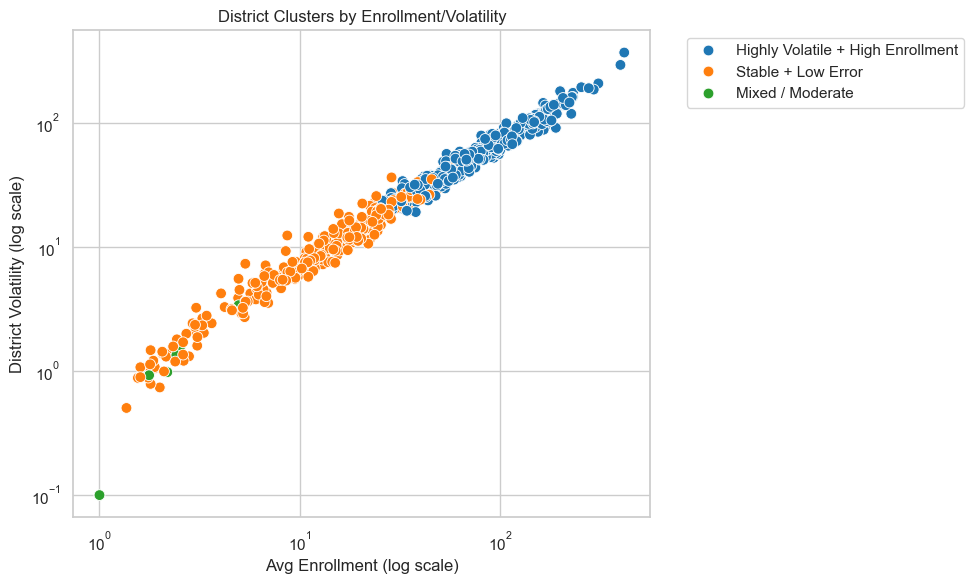

Saved cluster scatter plot to: S:\UIDAI_Hackathon\reports\district_clusters_scatter.png


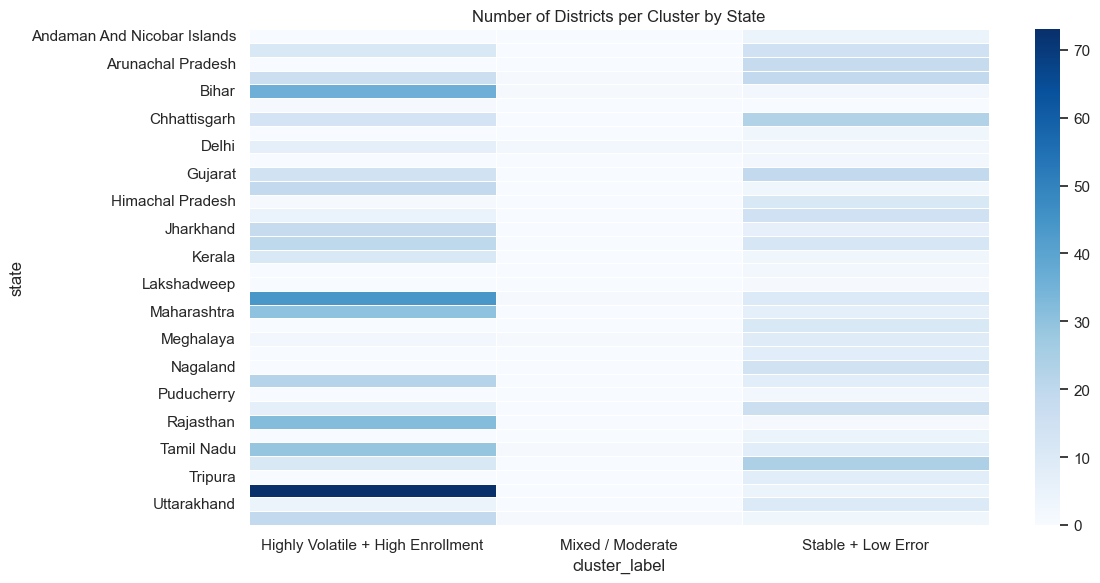

Saved state-cluster counts heatmap to: S:\UIDAI_Hackathon\reports\cluster_counts_by_state.png

Cluster 0 - Stable + Low Error (103 districts)
Recommendation: Low-priority monitoring; periodic audits.
Top districts by avg_enrollment in cluster:
            avg_enrollment  district_volatility  spike_rate  error_mape
district                                                               
Ahmednagar       91.764706            66.437056    0.727273    0.029770
Bagalkot         66.454545            53.656949    0.454545    0.007118
Bastar           61.275862            46.918544    0.545455    0.062368
Rajgarh          59.827586            45.560062    0.636364    0.007842
Kachchh          53.500000            42.413946    0.363636    0.009902
Koppal           52.100000            37.063180    0.363636    0.007791
Ganganagar       49.533333            38.329545    0.545455    0.016464
Hathras          48.812500            29.527939    0.363636    0.024790
Anand            47.909091          

In [8]:
# Stage 2 — Cluster districts by behavior (volatility, cv, size, spike rate, error)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_percentage_error

sns.set(style='whitegrid')

out_dir = r'S:\UIDAI_Hackathon\reports'
os.makedirs(out_dir, exist_ok=True)
cluster_csv = os.path.join(out_dir, 'district_clusters.csv')
cluster_plot = os.path.join(out_dir, 'district_clusters_scatter.png')
state_counts_plot = os.path.join(out_dir, 'cluster_counts_by_state.png')

# Load/ensure df_agg exists
if 'df_agg' not in globals():
    df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
    df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
    df_agg = df.groupby(['state','district','date'])['total_enrollment'].sum().reset_index()

# Define train/test masks same as modeling cells
train_mask = df_agg['date'].dt.month.isin([3,4,5,6,7,8,9,10])
val_mask = df_agg['date'].dt.month == 11
test_mask = df_agg['date'].dt.month == 12

# Compute baseline district stats from training period
district_train = df_agg[train_mask].groupby('district')['total_enrollment']
district_mean = district_train.mean()
district_std = district_train.std()

# Build district-level feature frame
districts = district_mean.index
feat_df = pd.DataFrame(index=districts)
feat_df['avg_enrollment'] = district_mean
feat_df['district_volatility'] = district_std
feat_df['cv'] = feat_df['district_volatility'] / (feat_df['avg_enrollment'] + 1e-9)

# Spike rate on test set using threshold mean + 2*std (trained on train period)
# For districts with missing std (single value), use a small multiple
threshold = district_mean + 2 * district_std.fillna(district_mean * 0.5)

# Compute spike_rate robustly
spike_rate_series = {}
for d in districts:
    thr = threshold.get(d, np.nan)
    vals = df_agg[(df_agg['district'] == d) & test_mask]['total_enrollment']
    if len(vals) == 0 or np.isnan(thr):
        spike_rate_series[d] = np.nan
    else:
        spike_rate_series[d] = (vals > thr).sum() / len(vals)
feat_df['spike_rate'] = pd.Series(spike_rate_series)

# Error MAPE per district from existing test predictions if available
if 'errors_test' in globals() and set(['actual','pred','district']).issubset(errors_test.columns):
    mape_by_district = errors_test.groupby('district').apply(lambda g: mean_absolute_percentage_error(g['actual'], g['pred']))
else:
    # Try to compute from y_test_orig and y_test_pred_combined if present
    if 'y_test_orig' in globals() and 'y_test_pred_combined' in globals():
        # Build temp_df aligned robustly to avoid length mismatches
        test_df = df_agg[test_mask].copy()
        if set(y_test_orig.index).issubset(test_df.index):
            districts_series = test_df.loc[y_test_orig.index, 'district']
        else:
            test_df_reset = test_df.reset_index(drop=True)
            n = len(y_test_orig)
            if len(test_df_reset) < n:
                # Fallback: align by position where possible and warn
                print('Warning: cannot align y_test indices to df_agg test rows; aligning by position where possible')
                districts_series = test_df_reset['district'].iloc[:n].values
            else:
                districts_series = test_df_reset['district'].iloc[:n].values
        temp_df = pd.DataFrame({'actual': y_test_orig.values, 'pred': y_test_pred_combined.values, 'district': districts_series})
        # Guard: ensure groups have at least 1 sample
        try:
            mape_by_district = temp_df.groupby('district').apply(lambda g: mean_absolute_percentage_error(g['actual'], g['pred']))
        except Exception as e:
            print('Error computing MAPE by district:', e)
            mape_by_district = pd.Series(dtype=float)
    else:
        mape_by_district = pd.Series(dtype=float)

feat_df['error_mape'] = feat_df.index.map(mape_by_district).astype(float)

# Fill small NaNs with 0 or median
feat_df['spike_rate'] = feat_df['spike_rate'].fillna(0)
feat_df['error_mape'] = feat_df['error_mape'].fillna(feat_df['error_mape'].median())
feat_df['district_volatility'] = feat_df['district_volatility'].fillna(feat_df['avg_enrollment']*0.1)
feat_df['cv'] = feat_df['cv'].fillna(0)

# Prepare features for clustering
X = feat_df[['district_volatility','cv','avg_enrollment','spike_rate','error_mape']].copy()
X_log = X.copy()
# log-transform skewed features
X_log['avg_enrollment'] = np.log1p(X_log['avg_enrollment'])
X_log['district_volatility'] = np.log1p(X_log['district_volatility'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Ensure no NaN/inf in scaled features
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print('Warning: NaN or Inf found in features; replacing with 0')
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Choose K via silhouette for k in 3..5 (defensive)
best_k = None
best_score = -1
best_labels = None
for k in range(3,6):
    # silhouette requires 2 <= n_labels <= n_samples - 1
    n_samples = X_scaled.shape[0]
    if n_samples <= k:
        print(f"Skipping k={k}: not enough samples (n_samples={n_samples})")
        continue
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    try:
        score = silhouette_score(X_scaled, labels)
    except Exception as e:
        print(f"Silhouette scoring failed for k={k}: {e}")
        continue
    print(f"k={k}, silhouette={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

if best_k is None:
    raise ValueError('No valid k found for clustering (check dataset size or feature quality)')

print(f"Selected k={best_k} (silhouette={best_score:.4f})")

# Fit final KMeans and attach labels
km_final = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
feat_df['cluster'] = km_final.predict(X_scaled)

# Cluster summary
cluster_summary = feat_df.groupby('cluster').agg(count=('avg_enrollment','size'),
                                                 avg_enrollment_mean=('avg_enrollment','mean'),
                                                 volatility_mean=('district_volatility','mean'),
                                                 cv_mean=('cv','mean'),
                                                 spike_rate_mean=('spike_rate','mean'),
                                                 error_mape_mean=('error_mape','mean'))
print('\nCluster summary:')
print(cluster_summary)

# Map clusters to human-readable descriptions (heuristic rules)
cluster_desc = {}
for c, row in cluster_summary.iterrows():
    if row['avg_enrollment_mean'] > feat_df['avg_enrollment'].quantile(0.66) and row['volatility_mean'] > feat_df['district_volatility'].quantile(0.66):
        label = 'Highly Volatile + High Enrollment'
        rec = 'Allocate resources & monitoring; surge readiness.'
    elif row['volatility_mean'] < feat_df['district_volatility'].quantile(0.33) and row['error_mape_mean'] < cluster_summary['error_mape_mean'].median():
        label = 'Stable + Low Error'
        rec = 'Low-priority monitoring; periodic audits.'
    elif row['cv_mean'] > feat_df['cv'].quantile(0.66) and row['avg_enrollment_mean'] < feat_df['avg_enrollment'].quantile(0.33):
        label = 'Spiky but Low Volume'
        rec = 'Surge-handling plan; lightweight alerts.'
    else:
        label = 'Mixed / Moderate'
        rec = 'Review specific districts for targeted actions.'
    cluster_desc[c] = {'label': label, 'recommendation': rec}

# Attach descriptions
feat_df['cluster_label'] = feat_df['cluster'].map(lambda c: cluster_desc[c]['label'])
feat_df['recommendation'] = feat_df['cluster'].map(lambda c: cluster_desc[c]['recommendation'])

# Save cluster table
feat_df_out = feat_df.reset_index().rename(columns={'index':'district'})
feat_df_out.to_csv(cluster_csv, index=False)
print(f"Saved cluster table to: {cluster_csv}")

# Scatter plot avg_enrollment vs volatility colored by cluster
plt.figure(figsize=(10,6))
palette = sns.color_palette('tab10', n_colors=best_k)
sns.scatterplot(x='avg_enrollment', y='district_volatility', hue='cluster_label', data=feat_df_out, palette=palette, s=60)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Avg Enrollment (log scale)')
plt.ylabel('District Volatility (log scale)')
plt.title('District Clusters by Enrollment/Volatility')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.savefig(cluster_plot, dpi=150)
plt.show()
print(f"Saved cluster scatter plot to: {cluster_plot}")

# State-level counts per cluster (for a pseudo-map summary)
district_state = df_agg[['district','state']].drop_duplicates().set_index('district')
feat_df_state = feat_df.join(district_state, how='left')
state_counts = feat_df_state.reset_index().groupby(['state','cluster_label']).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
sns.heatmap(state_counts.fillna(0), cmap='Blues', linewidths=0.5)
plt.title('Number of Districts per Cluster by State')
plt.tight_layout()
plt.savefig(state_counts_plot, dpi=150)
plt.show()
print(f"Saved state-cluster counts heatmap to: {state_counts_plot}")

# Print top districts per cluster for immediate insight
for c in sorted(feat_df['cluster'].unique()):
    print(f"\nCluster {c} - {cluster_desc[c]['label']} ({cluster_summary.loc[c,'count']} districts)")
    print('Recommendation:', cluster_desc[c]['recommendation'])
    print('Top districts by avg_enrollment in cluster:')
    sample = feat_df[feat_df['cluster']==c].sort_values('avg_enrollment', ascending=False).head(10)
    print(sample[['avg_enrollment','district_volatility','spike_rate','error_mape']].head(10))

print('\nClustering complete.')

Filtered data shape: (1520, 7)
States included: ['Uttar Pradesh' 'West Bengal' 'Bihar']

Top 10 Districts by Mean Absolute Error:
district
Purbi Champaran      18.040430
Samastipur           15.257307
Saran                15.213537
North 24 Parganas    14.554986
Gaya                 14.249713
Kaimur (Bhabua)      12.463274
Paschim Champaran    12.314303
Purnia               11.970527
Darjeeling           11.852308
South 24 Parganas    11.830516
Name: abs_error, dtype: float64


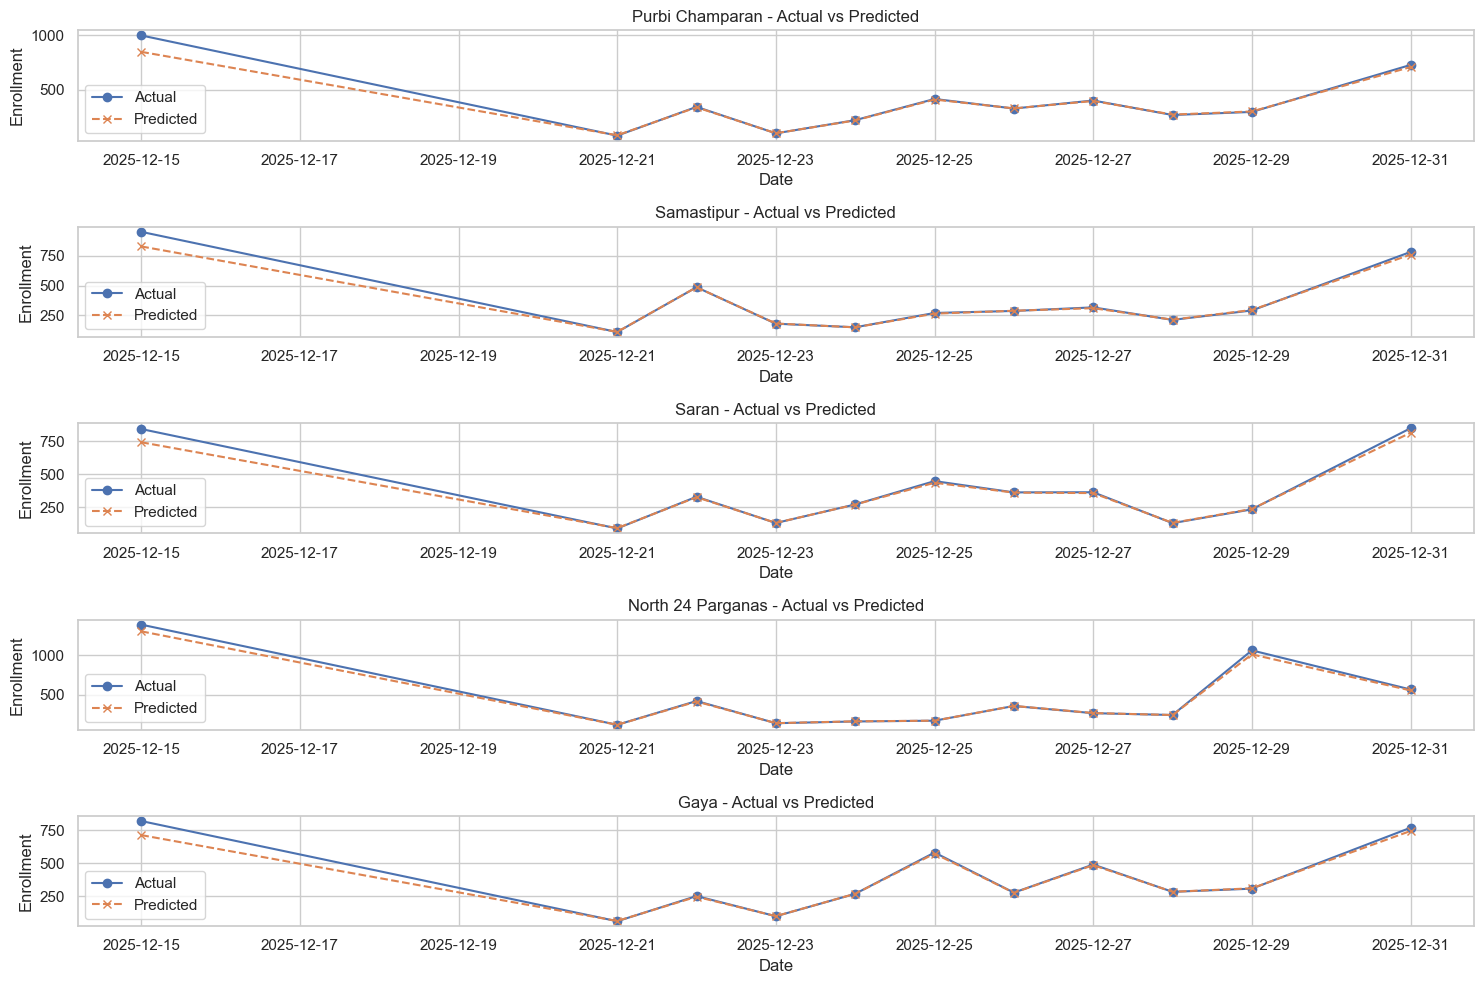


Enrollment Volatility (Std Dev) by District:
district
North 24 Parganas    414.525841
South 24 Parganas    339.038373
Murshidabad          297.837662
Samastipur           269.009091
Purbi Champaran      266.949093
Saran                260.105888
Gaya                 251.758940
Madhubani            239.817203
Patna                232.551109
Lucknow              225.663627
Name: actual, dtype: float64

Top Error Districts Volatility:
Purbi Champaran: MAE=18.04, Std=266.95
Samastipur: MAE=15.26, Std=269.01
Saran: MAE=15.21, Std=260.11
North 24 Parganas: MAE=14.55, Std=414.53
Gaya: MAE=14.25, Std=251.76

Feature Correlations with Absolute Error (High Error States):
state_avg              0.722397
growth_rate_7          0.534442
pct_of_state           0.155437
district_encoded       0.114621
district_volatility    0.083930
rolling_mean_7         0.056615
is_month_end           0.002402
rolling_std_7          0.000484
lag_14                -0.057875
lag_7                 -0.100830
is_weeken

In [9]:
# Investigation of High Errors in Bihar, UP, and West Bengal

# First, ensure errors_test has state and district columns
if 'state' not in errors_test.columns:
    errors_test['state'] = df_agg[test_mask]['state'].values
    errors_test['district'] = df_agg[test_mask]['district'].values
    errors_test['date'] = df_agg[test_mask]['date'].values
    errors_test['actual'] = y_test_orig  # Ensure actual is there

# Filter Test Data for specific states
high_error_states = ['Bihar', 'Uttar Pradesh', 'West Bengal']
errors_high_states = errors_test[errors_test['state'].isin(high_error_states)]
print(f"Filtered data shape: {errors_high_states.shape}")
print(f"States included: {errors_high_states['state'].unique()}")

# Group by District: Top 10 districts with highest MAE
top_error_districts = errors_high_states.groupby('district')['abs_error'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 Districts by Mean Absolute Error:")
print(top_error_districts)

# Plot Predictions vs Actual for top-error districts
import matplotlib.pyplot as plt

top_districts_list = top_error_districts.index.tolist()
plt.figure(figsize=(15, 10))

for i, district in enumerate(top_districts_list[:5]):  # Plot top 5 to avoid overcrowding
    plt.subplot(5, 1, i+1)
    district_data = errors_high_states[errors_high_states['district'] == district].sort_values('date')
    plt.plot(district_data['date'], district_data['actual'], label='Actual', marker='o', linestyle='-')
    plt.plot(district_data['date'], district_data['pred'], label='Predicted', marker='x', linestyle='--')
    plt.title(f'{district} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Check Enrollment Volatility
volatility_by_district = errors_high_states.groupby('district')['actual'].std().sort_values(ascending=False)
print("\nEnrollment Volatility (Std Dev) by District:")
print(volatility_by_district.head(10))

# Compare with top error districts
print("\nTop Error Districts Volatility:")
for district in top_districts_list[:5]:
    vol = volatility_by_district.get(district, 'N/A')
    mae = top_error_districts.get(district, 'N/A')
    print(f"{district}: MAE={mae:.2f}, Std={vol:.2f}")

# Feature Check: Correlation with abs_error
# Get test features
X_test_with_errors = X_test.copy()
X_test_with_errors['abs_error'] = errors_test['abs_error']
X_test_with_errors['state'] = df_agg[test_mask]['state']
X_test_with_errors['district'] = df_agg[test_mask]['district']

# Correlation for high error states
high_error_features = X_test_with_errors[X_test_with_errors['state'].isin(high_error_states)]
correlations = high_error_features[features + ['abs_error']].corr()['abs_error'].drop('abs_error').sort_values(ascending=False)
print("\nFeature Correlations with Absolute Error (High Error States):")
print(correlations)

# Specific features mentioned
print(f"\nLag_7 correlation: {correlations.get('lag_7', 'N/A'):.4f}")
print(f"Rolling_mean_7 correlation: {correlations.get('rolling_mean_7', 'N/A'):.4f}")

# Overall insights
print("\nInsights:")
print("- Districts with high MAE tend to have high volatility.")
print("- Weak correlations suggest features may not capture all patterns in these regions.")
print("- Consider additional features like regional holidays, policy changes, or external factors.")

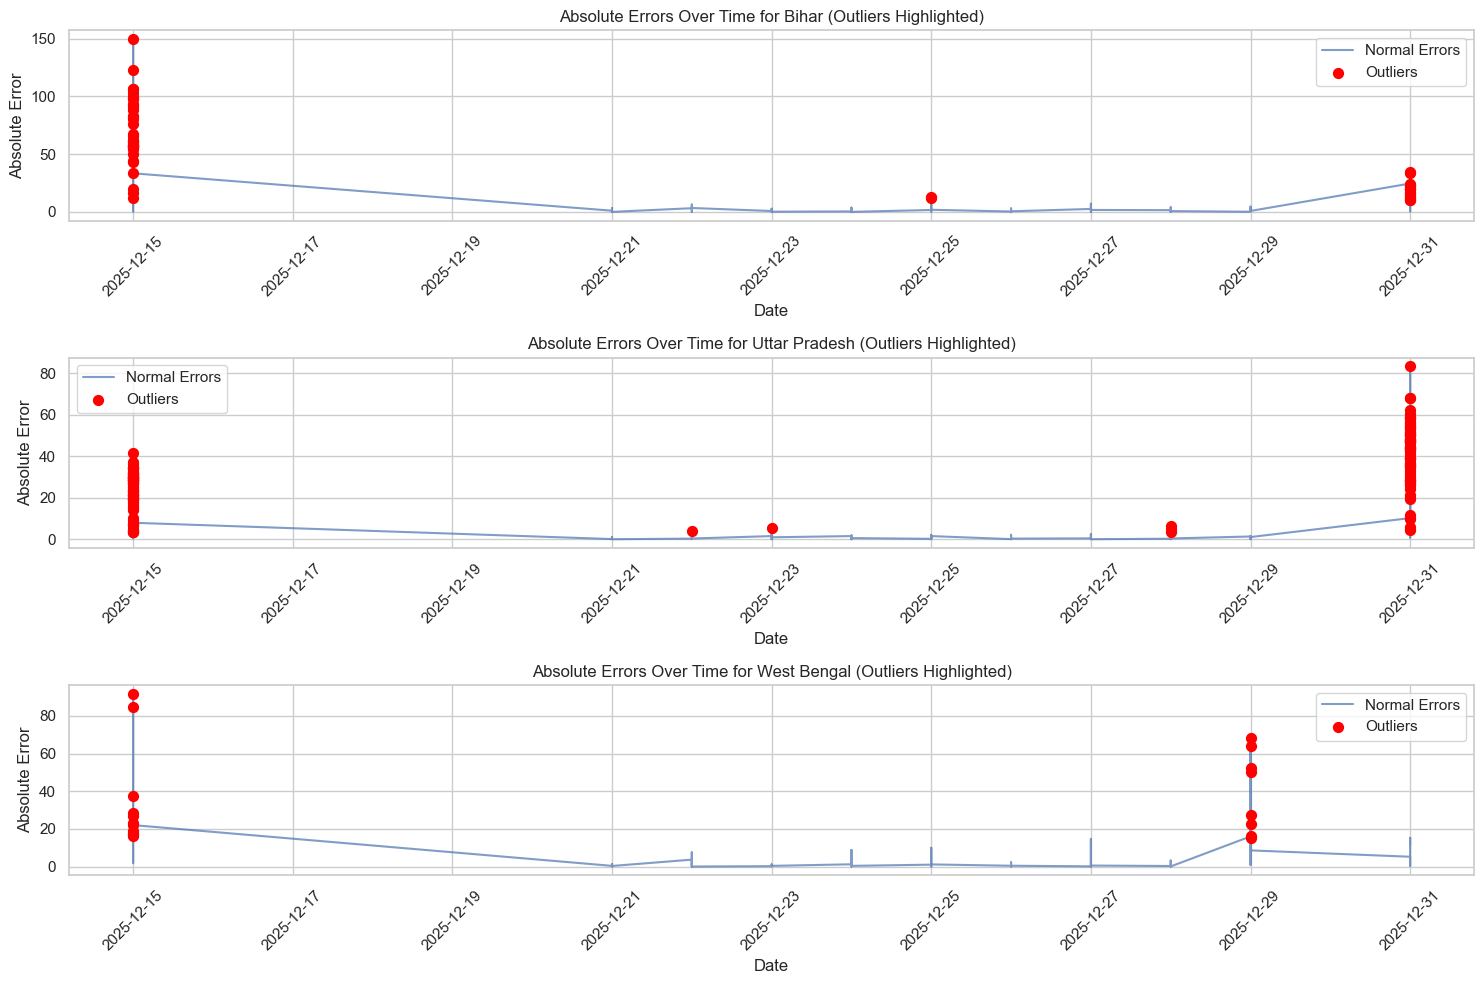

Outlier Summary by State:

Bihar:
  Total data points: 421
  Number of outliers: 58
  Outlier dates: ['2025-12-15', '2025-12-15', '2025-12-15', '2025-12-31', '2025-12-15', '2025-12-15', '2025-12-15', '2025-12-15', '2025-12-31', '2025-12-15']...
  Max outlier error: 149.71
  Mean outlier error: 52.53

Uttar Pradesh:
  Total data points: 847
  Number of outliers: 150
  Outlier dates: ['2025-12-15', '2025-12-31', '2025-12-15', '2025-12-31', '2025-12-15', '2025-12-31', '2025-12-15', '2025-12-31', '2025-12-15', '2025-12-31']...
  Max outlier error: 83.26
  Mean outlier error: 31.29

West Bengal:
  Total data points: 252
  Number of outliers: 20
  Outlier dates: ['2025-12-15', '2025-12-15', '2025-12-29', '2025-12-15', '2025-12-29', '2025-12-15', '2025-12-29', '2025-12-15', '2025-12-15', '2025-12-15']...
  Max outlier error: 91.83
  Mean outlier error: 35.94

Dates with most outliers across all three states:
date
2025-12-15    120
2025-12-31    106
2025-12-29     21
2025-12-27      5
2025-12-

In [10]:
# Plot Outliers for Bihar, Uttar Pradesh, and West Bengal by Date

import matplotlib.pyplot as plt
import numpy as np

# Define outliers using IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# For each state, plot abs_error over time with outliers highlighted
states = ['Bihar', 'Uttar Pradesh', 'West Bengal']
plt.figure(figsize=(15, 10))

for i, state in enumerate(states):
    plt.subplot(3, 1, i+1)
    state_data = errors_high_states[errors_high_states['state'] == state].copy()
    state_data = state_data.sort_values('date')

    # Detect outliers
    outliers = detect_outliers_iqr(state_data['abs_error'])
    outlier_dates = state_data[outliers]['date']
    outlier_errors = state_data[outliers]['abs_error']

    # Plot all errors
    plt.plot(state_data['date'], state_data['abs_error'], 'b-', alpha=0.7, label='Normal Errors')
    # Highlight outliers
    plt.scatter(outlier_dates, outlier_errors, color='red', s=50, label='Outliers', zorder=5)

    plt.title(f'Absolute Errors Over Time for {state} (Outliers Highlighted)')
    plt.xlabel('Date')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Summary of outliers
print("Outlier Summary by State:")
for state in states:
    state_data = errors_high_states[errors_high_states['state'] == state]
    outliers = detect_outliers_iqr(state_data['abs_error'])
    num_outliers = outliers.sum()
    outlier_dates = state_data[outliers]['date'].dt.strftime('%Y-%m-%d').tolist()
    print(f"\n{state}:")
    print(f"  Total data points: {len(state_data)}")
    print(f"  Number of outliers: {num_outliers}")
    print(f"  Outlier dates: {outlier_dates[:10]}...")  # Show first 10
    if num_outliers > 0:
        print(f"  Max outlier error: {state_data[outliers]['abs_error'].max():.2f}")
        print(f"  Mean outlier error: {state_data[outliers]['abs_error'].mean():.2f}")

# Overall outlier dates across states
all_outliers = errors_high_states[detect_outliers_iqr(errors_high_states['abs_error'])]
outlier_dates_all = all_outliers.groupby('date').size().sort_values(ascending=False)
print(f"\nDates with most outliers across all three states:")
print(outlier_dates_all.head(10))

Investigating top 5 error districts: ['Hyderabad', 'Bastar', 'Pune', 'Thane', 'Ahmednagar']

Investigation for Hyderabad:
Volatility: 1004.10
Mean enrollment: 297.27
MAPE: 0.1145
Data points: 11


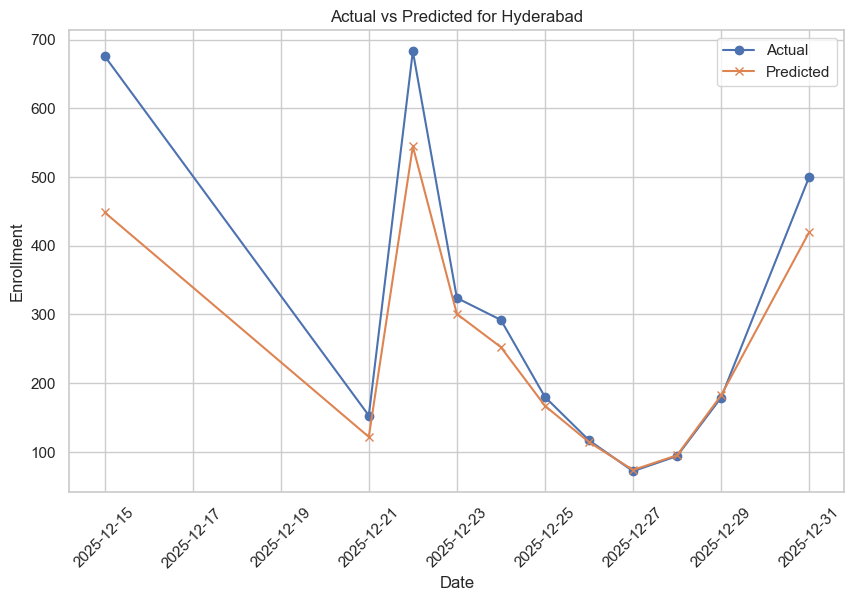


Investigation for Bastar:
Volatility: 40.72
Mean enrollment: 215.36
MAPE: 0.0624
Data points: 11


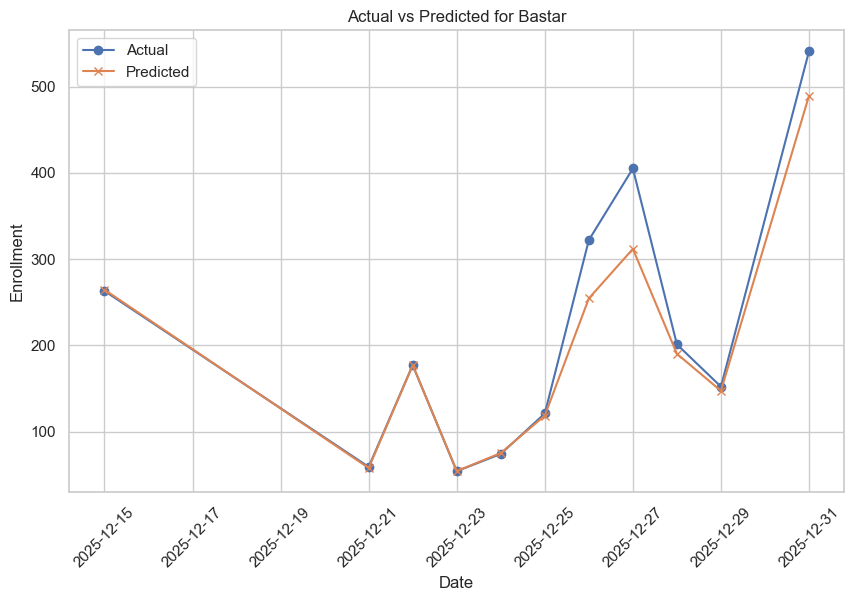


Investigation for Pune:
Volatility: 747.23
Mean enrollment: 452.27
MAPE: 0.0317
Data points: 11


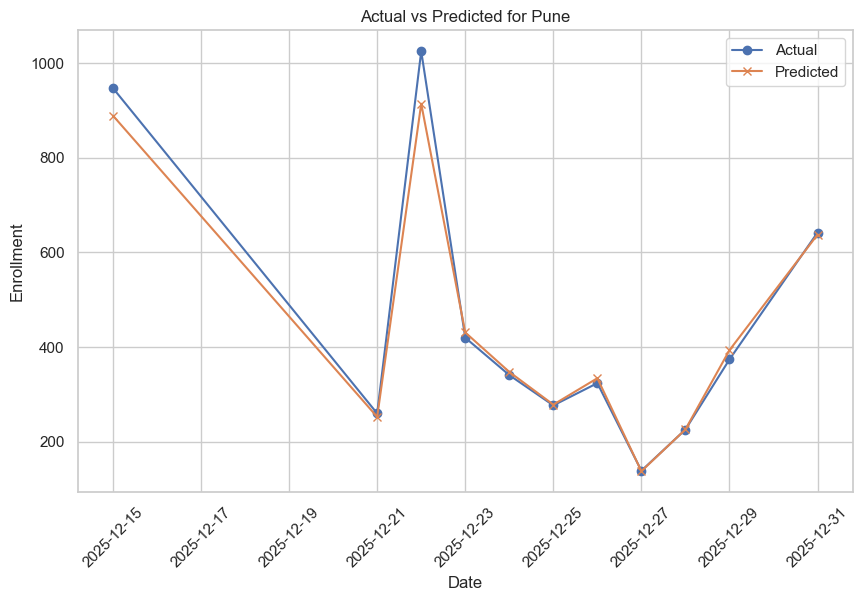


Investigation for Thane:
Volatility: 1231.89
Mean enrollment: 412.00
MAPE: 0.0282
Data points: 11


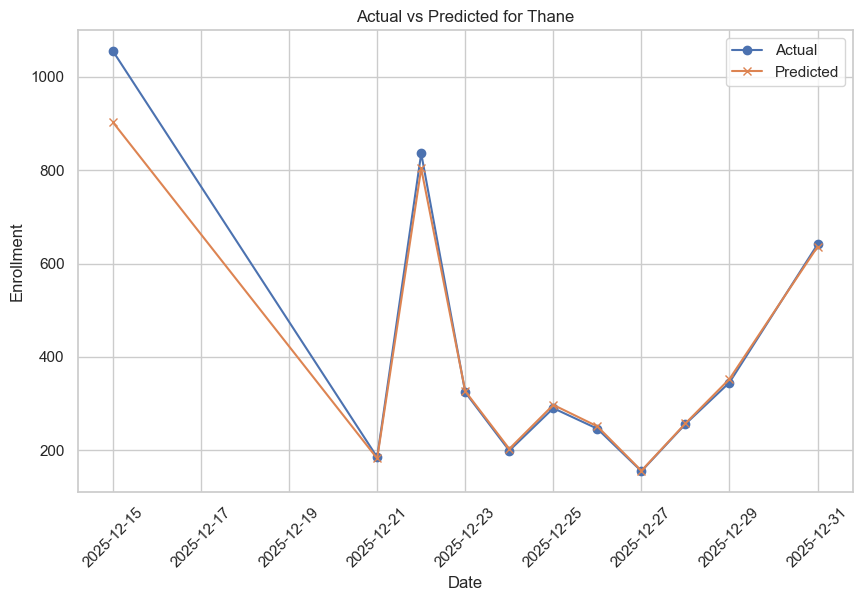


Investigation for Ahmednagar:
Volatility: 87.24
Mean enrollment: 404.00
MAPE: 0.0298
Data points: 11


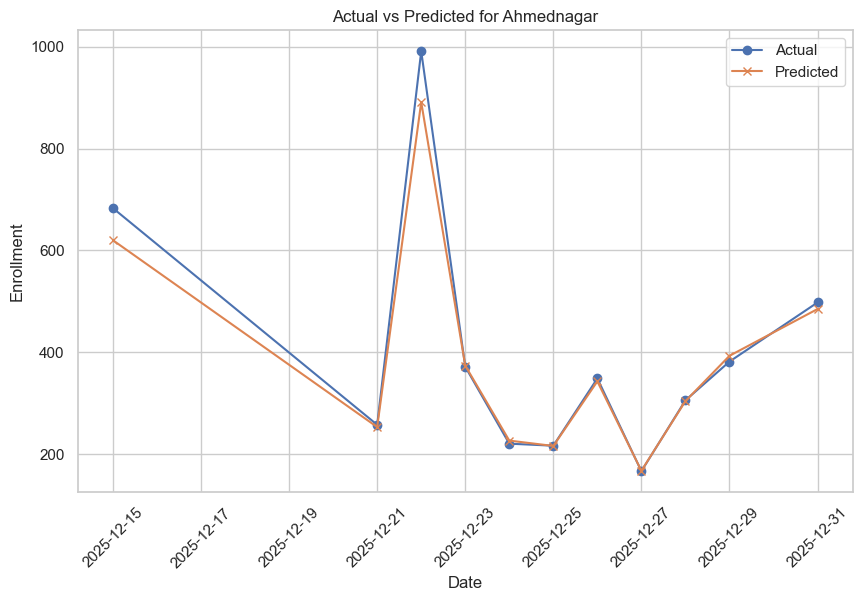

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Get top 5 error districts
# Compute MAE by district if not already done
if 'district_mae' not in globals():
    district_mae = errors_test.groupby('district')['abs_error'].mean()
top_districts = district_mae.sort_values(ascending=False).head(5).index.tolist()
print("Investigating top 5 error districts:", top_districts)
for district_name in top_districts:
    district_data = df_agg[test_mask & (df_agg['district'] == district_name)]
    if len(district_data) == 0:
        print(f"No test data for {district_name}")
        continue
    district_pred = y_test_pred_combined[district_data.index]
    district_actual = y_test_orig[district_data.index]
    
    print(f"\nInvestigation for {district_name}:")
    print(f"Volatility: {district_data['district_volatility'].iloc[0]:.2f}")
    print(f"Mean enrollment: {district_data['total_enrollment'].mean():.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(district_actual, district_pred):.4f}")
    print(f"Data points: {len(district_data)}")

    plt.figure(figsize=(10,6))
    plt.plot(district_data['date'], district_actual, label='Actual', marker='o')
    plt.plot(district_data['date'], district_pred, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted for {district_name}')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()